Explainable AI for Arctic sea ice forecasting with deep neural networks.

A CNN models was trained to predict the sea ice concentration (SIC, from 0 - 1) in the Barents Sea, with SIC and the change of ocean heat content (OHC) as inputs.

We use dianna to perform XAI analysis on the saved onnx model.

In [1]:
import dianna
import numpy as np
from pathlib import Path
import onnx
import onnxruntime

import torch
import xarray as xr

import matplotlib
import matplotlib.pyplot as plt

/home/yangliu/miniconda3/envs/ml/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Load and prepare data.

In [2]:
# path
path_data = Path("./data/")
# start and end time of the period of interest
start_year = 2000
end_year = 2017
# number of weeks per year (assuming each month contains 4 weeks)
nweeks = 48
# load preprocessed data - sea ice concentration
sic_xr = xr.load_dataset(path_data / "sic_erai_2000_2017.nc")
sic_xr

<xarray.Dataset>
Dimensions:    (year: 18, week: 48, latitude: 24, longitude: 56)
Coordinates:
  * year       (year) int32 2000 2001 2002 2003 2004 ... 2014 2015 2016 2017
  * week       (week) int32 1 2 3 4 5 6 7 8 9 10 ... 40 41 42 43 44 45 46 47 48
  * latitude   (latitude) float64 80.5 79.75 79.0 78.25 ... 64.75 64.0 63.25
  * longitude  (longitude) float64 18.0 18.75 19.5 20.25 ... 57.75 58.5 59.25
Data variables:
    sic        (year, week, latitude, longitude) float64 0.07345 ... -1.0
    mask       (latitude, longitude) int64 0 0 0 0 0 0 0 0 0 ... 1 1 1 1 1 1 1 1
Attributes:
    description:  Weekly Sea Ice Concentration

In [3]:
# load preprocessed data - ocean heat content
ohc_xr = xr.load_dataset(path_data /  "ohc_oras_2000_2017.nc")
ohc_xr

<xarray.Dataset>
Dimensions:    (year: 18, week: 48, latitude: 24, longitude: 56)
Coordinates:
  * year       (year) int32 2000 2001 2002 2003 2004 ... 2014 2015 2016 2017
  * week       (week) int32 1 2 3 4 5 6 7 8 9 10 ... 40 41 42 43 44 45 46 47 48
  * latitude   (latitude) float64 80.5 79.75 79.0 78.25 ... 64.75 64.0 63.25
  * longitude  (longitude) float64 18.0 18.75 19.5 20.25 ... 57.75 58.5 59.25
Data variables:
    ohc        (year, week, latitude, longitude) float64 108.1 108.1 ... 0.0 0.0
    mask       (latitude, longitude) int64 0 0 0 0 0 0 0 0 0 ... 1 1 1 1 1 1 1 1
Attributes:
    description:  Weekly ocean heat content (300m) change (Tera Joule) regrid...

In [4]:
# turn dataset into sequences
sic_seq = sic_xr.sic.values.reshape(-1, sic_xr.latitude.size, sic_xr.longitude.size)
ohc_seq = ohc_xr.ohc.values.reshape(-1, ohc_xr.latitude.size, ohc_xr.longitude.size)

# turn masked area from -1 to 0 (remove mask)
sic_seq[sic_seq < 0] = 0

def normalizer(x):
    max_value = np.amax(x)
    min_value = np.amin(x)
    y = (x - min_value)/(max_value - min_value)
    return y

# normalize ohc
ohc_norm_seq = normalizer(ohc_seq)

Prepare testing data.

In [5]:
# sic and ohc
input_channels = 2
# 12 years data used for training, in total 12 * 48 (weeks) data points (spatial maps)
train_years = 12
# investigate the time of interest in testing set
week_interest = 10
year_interest = 2015
timestep_test = train_years * nweeks + (year_interest - 2012) * nweeks + week_interest
X_test = torch.tensor(np.stack((sic_seq[timestep_test,:,:],
                                ohc_norm_seq[timestep_test,:,:]))
                        ).float().view(-1, input_channels, 
                                        sic_xr.latitude.size,
                                        sic_xr.longitude.size)
x_var = torch.autograd.Variable(X_test, requires_grad=False)

Load the pretrained onnx model.

In [6]:
onnx_model_path = './models/metnet.onnx'
onnx_model = onnx.load(onnx_model_path)
onnx.checker.check_model(onnx_model)
print(onnx.helper.printable_graph(onnx_model.graph))

graph torch-jit-export (
  %input[FLOAT, batch_sizex2x24x56]
) initializers (
  %layer1.0.weight[FLOAT, 2x2x5x5]
  %layer1.0.bias[FLOAT, 2]
  %layer2.0.weight[FLOAT, 3x2x5x5]
  %layer2.0.bias[FLOAT, 3]
  %layer3.0.weight[FLOAT, 5x3x5x5]
  %layer3.0.bias[FLOAT, 5]
  %layer4.0.weight[FLOAT, 3x5x5x5]
  %layer4.0.bias[FLOAT, 3]
  %layer5.0.weight[FLOAT, 1x3x5x5]
  %layer5.0.bias[FLOAT, 1]
) {
  %11 = Conv[dilations = [1, 1], group = 1, kernel_shape = [5, 5], pads = [2, 2, 2, 2], strides = [1, 1]](%input, %layer1.0.weight, %layer1.0.bias)
  %12 = Relu(%11)
  %13 = Conv[dilations = [1, 1], group = 1, kernel_shape = [5, 5], pads = [2, 2, 2, 2], strides = [1, 1]](%12, %layer2.0.weight, %layer2.0.bias)
  %14 = Relu(%13)
  %15 = Conv[dilations = [1, 1], group = 1, kernel_shape = [5, 5], pads = [2, 2, 2, 2], strides = [1, 1]](%14, %layer3.0.weight, %layer3.0.bias)
  %16 = Relu(%15)
  %17 = Conv[dilations = [1, 1], group = 1, kernel_shape = [5, 5], pads = [2, 2, 2, 2], strides = [1, 1]](%16, %laye

Make predictions with the loaded onnx model.

In [7]:
test_sample = x_var.detach().numpy().astype(np.float32)
# # get ONNX predictions
sess = onnxruntime.InferenceSession(onnx_model_path)
input_name = sess.get_inputs()[0].name
output_name = sess.get_outputs()[0].name
    
onnx_input = {input_name: test_sample}
pred_onnx = sess.run([output_name], onnx_input)[0]

Model evaluation.

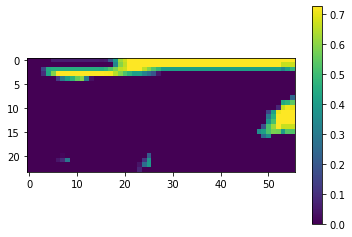

In [8]:
plt.imshow(pred_onnx[0,0,:,:])
plt.colorbar()

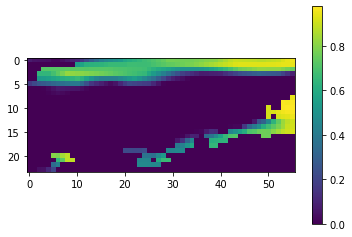

In [9]:
plt.imshow(sic_seq[timestep_test+1,:,:]) # plus one because model predicts one timestep ahead
plt.colorbar()

Perform XAI - example of RISE

In [11]:
relevances = dianna.explain_image(onnx_model_path, test_sample[0,:,:,:], method="RISE",
                                labels=[i for i in range(20)],
                                n_masks=1000, feature_res=8, p_keep=.1,
                                axis_labels=('channels','height','width'))

Explaining: 100%|██████████| 10/10 [00:00<00:00, 53.15it/s]


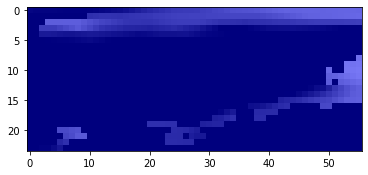

In [15]:
from dianna import visualization
visualization.plot_image(relevances[0], test_sample[0,:,:,:][0], data_cmap='gray', heatmap_cmap='bwr')

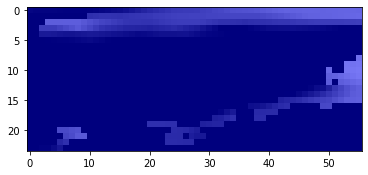

In [16]:
from dianna import visualization
visualization.plot_image(relevances[19], test_sample[0,:,:,:][0], data_cmap='gray', heatmap_cmap='bwr')

Perform XAI - example of KernelShap

In [17]:
# xai with dianna
# use KernelSHAP to explain the network's predictions
shap_values, segments_slic = dianna.explain_image(onnx_model_path, test_sample[0,:,:,:],
                                                  labels=(2,1,10,10),
                                                  method="KernelSHAP", nsamples=100,
                                                  background=0, n_segments=100, sigma=0,
                                                  axis_labels=('channels','height','width'))

2022-08-18 15:43:35.711023: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-08-18 15:43:35.711092: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2022-08-18 15:43:37.938853: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2022-08-18 15:43:37.938914: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2022-08-18 15:43:37.938955: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (NLeSC0068): /proc/driver/nvidia/version does not exist
2022-08-18 15:43:37.939356: I tensorflow/core/platform/cpu_feature_

ValueError: cannot reshape array of size 537600 into shape (400,1)

Perform XAI - example of LIME

In [22]:
explanation_heatmap = dianna.explain_image(onnx_model_path, test_sample, 'LIME', axis_labels={2: 'channels'}, labels=[i for i in range(20)])

ValueError: only 2D color images are supported